In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### High-dimensional vectors
To get an intuition about the working of the PCA, we used an example in the plane, or $R^2$.
While useful for intuition, this is not the typical case in which we use PCA. Typically we are interested in vectors in a space whose dimension is in the hundreds or more.

How can we depict such vectors? If the coordinates of the vector have a natural order. For example, if the coordinates correspond to a grid of times, then a good representation is to make a plot in which the $x$-axis is the time and the $y$-axis is the value that corresponds to this time. 

Later in this class we will consider vectors that correspond to the temperature at a particular location each day of the year. These vectors will be of length 365 (we omit the extra days of leap years) and the PCA analysis will reveal the low dimensional subspace.

### Function approximation
For now, we will consider the vectors that are defined by sinusoidal functions.

In [2]:
# We define a grid that extends from o to 2*pi
step=2*pi/365
x=arange(0,2*pi,step)
len(x)

365

### Define a basis

The dimension of the space is 629.

We define some functions based on $\sin()$ and $\cos()$ 

In [3]:
c=sqrt(step/(pi))
v=[]
v.append(np.array(cos(0*x))*c/sqrt(2))
v.append(np.array(sin(x))*c)
v.append(np.array(cos(x))*c)
v.append(np.array(sin(2*x))*c)
v.append(np.array(cos(2*x))*c)
v.append(np.array(sin(3*x))*c)
v.append(np.array(cos(3*x))*c)
v.append(np.array(sin(4*x))*c)
v.append(np.array(cos(4*x))*c)

print"v contains %d vectors"%(len(v))


v contains 9 vectors


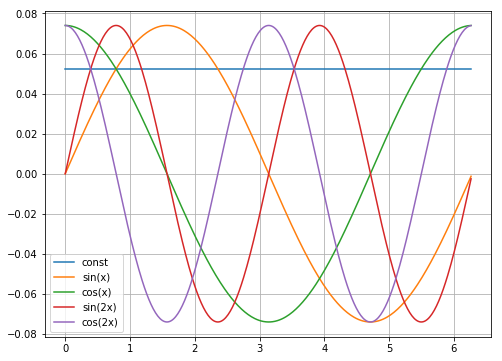

In [4]:
# plot some of the functions (plotting all of them results in a figure that is hard to read.
figure(figsize=(8,6))
for i in range(5):
    plot(x,v[i])
grid()
legend(['const','sin(x)','cos(x)','sin(2x)','cos(2x)'])

### This is an orthonormal basis
This basis is not **complete** it does not span the space of all functions. It spans a 9 dimensional sub-space.

We will now check that this is an **orthonormal** basis. In other words, the length of each vector is 1 and every pair of vectors are orthogonal.

In [5]:
for i in range(len(v)): 
    print
    for j in range(len(v)):
        print '%6.3f\t'%dot(v[i],v[j]),


 1.000	 0.000	-0.000	 0.000	-0.000	 0.000	-0.000	 0.000	-0.000	
 0.000	 1.000	 0.000	-0.000	 0.000	-0.000	 0.000	-0.000	-0.000	
-0.000	 0.000	 1.000	 0.000	-0.000	 0.000	-0.000	 0.000	-0.000	
 0.000	-0.000	 0.000	 1.000	 0.000	-0.000	-0.000	-0.000	-0.000	
-0.000	 0.000	-0.000	 0.000	 1.000	-0.000	-0.000	 0.000	-0.000	
 0.000	-0.000	 0.000	-0.000	-0.000	 1.000	-0.000	 0.000	-0.000	
-0.000	 0.000	-0.000	-0.000	-0.000	-0.000	 1.000	-0.000	-0.000	
 0.000	-0.000	 0.000	-0.000	 0.000	 0.000	-0.000	 1.000	 0.000	
-0.000	-0.000	-0.000	-0.000	-0.000	-0.000	-0.000	 0.000	 1.000	

### Rewriting the basis as a matrix

Combining the vectors as rows in a matrix allows us use very succinct (and very fast) matrix multiplications instead of for loops with vector products.

In [6]:
U=vstack(v)
shape(U)

(9, 365)

### Approximating a function
We now take an unrelated function $f=|x-4|$
and see how we can use the basis matrix `U` to approximate it. 

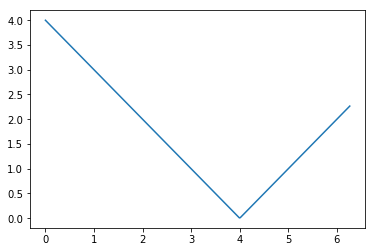

In [19]:
f=abs(x-4)
plot(x,f);

### Approximations  of increasing accuracy
To understand the workings of the basis, we create a sequence of approximations $g(i)$ such that $g(i)$ is an approximation that uses the first $i$ vectors in the basis.

The larger $i$ is, the closer $g(i)$ is to $f$. Where the distance between $f$ and $g(i)$ is defined by the euclidean norm:
$$   \| g(i)- f \|_2
$$

### Plotting the approximations
Below we show how increasing the number of vectors in the basis improves the approximation of $f$.

In [8]:
import sys
sys.path.append('lib')
from recon_plot import recon_plot
from YearPlotter import YearPlotter

In [ ]:
fi

In [16]:
%%writefile lib/YearPlotter.py
from datetime import date
from numpy import shape
from matplotlib.dates import MonthLocator, DateFormatter
class YearPlotter:
    def __init__(self):
        start=365*1+1
        self.dates=[date.fromordinal(i) for i in range(start,start+365)]
        self.monthsFmt = DateFormatter("%b")
        self.months = MonthLocator(range(1, 13), bymonthday=1, interval=1)

    def plot(self,T,fig,ax,label='',title=None):
        if shape(T)[0] != 365:
            raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
        ax.plot(self.dates,T,label=label);
        ax.xaxis.set_major_locator(self.months)
        ax.xaxis.set_major_formatter(self.monthsFmt)
        if not title is None:
            ax.set_title(title)
        # rotate and align the tick labels so they look better
        fig.autofmt_xdate()
        ax.grid()
        

Overwriting lib/YearPlotter.py


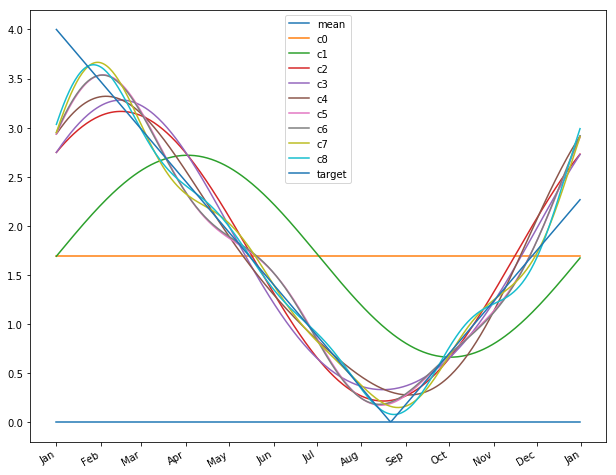

In [22]:
recon_plot(x,f,np.zeros(len(f)),v,year_axis=True);

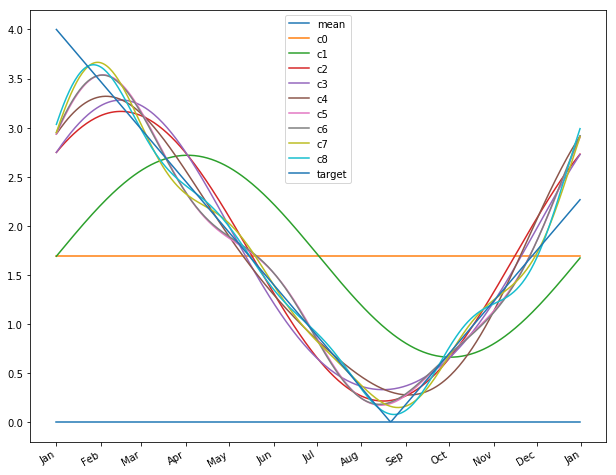

In [23]:
import numpy as np
from ipywidgets import interactive,widgets
plotter=recon_plot(x,f,np.zeros(len(f)),v,year_axis=True)
widge_list,widge_dict = plotter.get_widgets()
interactive(plotter.plot_combination, **widge_dict)
widgets.VBox([widgets.HBox(widge_list)])


### Excercise
Visually, it is clear that $g(i)$ is getting close to $f$ as $i$ increases. To quantify the improvement, calculate 
$ \| g(i)- f \|_2 $ as a function of $i$

### How we use PCA
This notebook demonstrates how orthonormal basis can be use to approaximate functions.
Here we used functions that are described by a simple formula.

When we analyze natural signals, ours vectors come from some complex distribution. PCA helps us find if the
distribution is concentrated close to a low dimensional affine space. If it is, then the top $k$ eigenvectors define the manifold and projecting the vector on these eigenvectors gives us an approximation that is, on average, close to the true vector.

In [10]:
def f(label='a'):
    g(label=label)
def g(label='ff'):
    print label
g()

ff


In [11]:
f()

a


In [12]:
f('anything')

anything
